In [49]:

"""
Functions to analyse results
Note:
when you load a mask.nii file (both ground truth and predicted mask)
use
sitk.ReadImage(path_to_file)>0
in order to get a binary image!
"""
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd
import get_data as gd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
def calculate_dice(mask_a, mask_b):
    """
    Calculate DICE score for two binary masks (=sitk images)
    """
    npa1 = sitk.GetArrayFromImage(mask_a)
    npa2 = sitk.GetArrayFromImage(mask_b)

    dice = 2*np.count_nonzero(npa1 & npa2) / (np.count_nonzero(npa1) + np.count_nonzero(npa2))
    return dice

def calculate_msd(mask_a, mask_b):
    """
    Calulate mean average surface distance between mask a and b
    """
    mask_b.CopyInformation(mask_a)
    # masks need to occupy exactly the same space and no spacial information is
    # saved in the matlab script

    contour_list =[sitk.LabelContour(m) for m in [mask_a, mask_b]]

    n_voxel = []
    mean_val = []

    for a, b in [(0,1), (1,0)]:
        distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(contour_list[a],
                                                         squaredDistance=False,
                                                         useImageSpacing=True))
        stat_intensity_filter = sitk.LabelIntensityStatisticsImageFilter()
        stat_intensity_filter.Execute(contour_list[b], distance_map)
        n_voxel.append(stat_intensity_filter.GetNumberOfPixels(1))
        mean_val.append(stat_intensity_filter.GetMean(1))

    # combine the two values to get 'symmetric' values
    MSD=(n_voxel[0]*mean_val[0]+n_voxel[1]*mean_val[1])/(n_voxel[0]+n_voxel[1])

    return MSD

def mean_columns(dataframe):
    dict = {}
    for column in dataframe:
        dict[column] = [dataframe[column].mean()]
    return dict

In [3]:
#result_folder = '/Volumes/My Passport/Ingvild_results'
result_folder = '/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed'

resultPaths = {}


for experiment in os.listdir(result_folder):
    experimentPath = os.path.join(result_folder, experiment)
    if os.path.isdir(experimentPath):
        for patient in os.listdir(experimentPath):
            patientResultPath = os.path.join(experimentPath, patient)
            if experiment in resultPaths:
                resultPaths[experiment].append(patientResultPath)
            else:
                resultPaths[experiment] = [patientResultPath]

In [4]:
def performance(resultPath_list, groundtruthPath_list):
    
    dice = {}
    msd = {}

    for key in resultPath_list:
        print(key)
        
        # Keeps only NIfTI files (.nii) from the results
        resultPath_list[key] = [filename for filename in resultPath_list[key] if filename.endswith(".nii")]
        
        for i in range(len(groundtruthPath_list)):
            print(resultPath_list[key][i])
            print(groundtruthPath_list[i])
            if resultPath_list[key][i].endswith('.nii'):
                try:
                    mask_pred = sitk.ReadImage(resultPath_list[key][i]) > 0
                    mask_truth = sitk.ReadImage(groundtruthPath_list[i]) > 0
                    dice_score = calculate_dice(mask_pred, mask_truth)
                    msd_score = calculate_msd(mask_pred, mask_truth)
                    if key in dice:
                        dice[key].append(dice_score)
                        msd[key].append(msd_score)
                    else:
                        dice[key] = [dice_score]
                        msd[key] = [msd_score]
                except RuntimeError:
                    print('Empty label mask - returns DSC = 0 and MSD = NaN')
                    if key in dice:
                        dice[key].append(0)
                        msd[key].append(np.nan)
                    else:
                        dice[key] = [0]
                        msd[key] = [np.nan]
                except ValueError:
                    print('ValueError')
                    if key in dice:
                        dice[key].append(0)
                        msd[key].append(np.nan)
                    else:
                        dice[key] = [0]
                        msd[key] = [np.nan]
    
    return dice, msd

In [5]:
def dataframes(dsc_dict, msd_dict):

    df_dice = pd.DataFrame(dsc_dict)
    df_msd = pd.DataFrame(msd_dict)
    mean_dice = mean_columns(df_dice)
    mean_msd = mean_columns(df_msd)

    df_dice_mean = pd.DataFrame(mean_dice)
    df_msd_mean = pd.DataFrame(mean_msd)
    
    df_dice_median = df_dice.median()
    df_msd_median = df_msd.median()
    
    return df_dice, df_msd, df_dice_mean, df_msd_mean, df_dice_median, df_msd_median

In [6]:
main_folder = '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected'
image_prefix = 'image'

patientsPaths_corrected = []
patientsPaths_image_corrected = []
patientsPaths_groundTruth_corrected = []
patientsNames_corrected = []

for entry in os.listdir(main_folder):
    if not entry.endswith('.DS_Store'):
        patientsPath = os.path.join(main_folder, entry)
        #print(patientsPath)
        if os.path.isdir(patientsPath):
            patientsPaths_corrected.append(patientsPath)
            patientsNames_corrected.append(entry)
            
            for i in os.listdir(patientsPath):
                if i.startswith(image_prefix):
                    patientsPaths_image_corrected.append(os.path.join(patientsPath,i))
                else:
                    patientsPaths_groundTruth_corrected.append(os.path.join(patientsPath,i))
            
print(patientsPaths_groundTruth_corrected)

['/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-010/1 RTSTRUCT LARC_MRS1-label.nii', 

# LARC performance

In [7]:
LARC_patients, LARC_patientsNames, LARC_imagePaths, LARC_groundTruthPaths = gd.get_paths('/Volumes/Untitled/LARC_T2_preprocessed', image_prefix='image', mask_suffix='label.nii')
LARC_groundTruthPaths.insert(0, LARC_groundTruthPaths.pop(len(LARC_groundTruthPaths) - 1))
#print(LARC_groundTruthPaths)

In [8]:
LARC_keys = ['ID_0','ID_1','ID_2','ID_3','ID_4','ID_5','ID_6','ID_7','ID_8'] 
resultPaths_LARC = {x:resultPaths[x] for x in LARC_keys}

#dsc_LARC, msd_LARC = performance(resultPaths_LARC, LARC_groundTruthPaths)
dsc_LARC, msd_LARC = performance(resultPaths_LARC, patientsPaths_groundTruth_corrected)

ID_0
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-001.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-003.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-004.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-005.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-048.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-048/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-049.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-049/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-050.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-050/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-051.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-051/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-052.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-052/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-096.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-096/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-099.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-099/1 RTSTRUCT LARC_MRS1-label.nii
ID_1
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-001.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-003.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-004.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-047.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-047/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-048.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-048/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-049.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-049/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-050.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-050/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-051.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-051/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-095.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-095/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-096.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-096/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1/LARC-RRP-099.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-099/1 RTSTRUCT LARC_MRS1-label.nii
ID_2
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-001.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-003.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-043.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-043/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-044.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-044/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-045.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-045/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-047.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-047/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-048.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-048/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-092.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-092/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-093.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-093/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-094.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-094/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-095.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-095/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2/LARC-RRP-096.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-096/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-041.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-042.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-042/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-043.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-043/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-044.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-044/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-045.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-045/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-088.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-088/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-089.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-089/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-090.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-090/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-091.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-091/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3/LARC-RRP-092.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-092/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-037.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-037/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-038.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-038/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-039.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-040.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-040/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-041.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-086.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-086/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-087.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-087/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-088.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-088/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-089.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-089/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4/LARC-RRP-090.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-090/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-037.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-037/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-038.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-038/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-039.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-040.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-040/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-041.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-085.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-085/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-086.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-086/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-087.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-087/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-088.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-088/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5/LARC-RRP-089.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-089/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-033.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-033/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-034.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-034/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-035.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-035/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-036.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-036/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-037.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-037/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-079.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-079/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-080.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-080/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-081.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-081/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-083.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-083/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6/LARC-RRP-084.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-084/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-031.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-031/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-032.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-032/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-033.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-033/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-034.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-034/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-035.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-035/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-077.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-077/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-078.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-078/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-079.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-079/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-080.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-080/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7/LARC-RRP-081.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-081/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-026.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-026/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-027.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-027/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-028.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-028/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-029.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-029/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-030.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-030/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-072.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-072/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-073.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-073/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-074.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-074/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-075.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-075/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-076.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-076/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ing

In [9]:
df_dsc_LARC, df_msd_LARC, df_dscMean_LARC, df_msdMean_LARC, df_dscMedian_LARC, df_msdMedian_LARC = dataframes(dsc_LARC, msd_LARC)

LARC_dfs = [df_dsc_LARC, df_msd_LARC, df_dscMean_LARC, df_msdMean_LARC]

for df in LARC_dfs:
    df.rename(columns={'ID_0':'LDA+R0_2D','ID_1':'LDA+R1_2D','ID_2':'LDA+R1_3D','ID_3':'QDA+R0_2D','ID_4':'QDA+R1_2D','ID_5':'QDA+R1_3D','ID_6':'SVM+R0_2D','ID_7':'SVM+R1_2D','ID_8':'SVM+R1_3D'}, inplace=True)


In [10]:
print(df_dsc_LARC)
print(df_msd_LARC)
print((df_dscMean_LARC.transpose()).to_latex())
print((df_msdMean_LARC.transpose()).to_latex())
print(df_dscMedian_LARC)
print(df_msdMedian_LARC)

    LDA+R0_2D  LDA+R1_2D  LDA+R1_3D  QDA+R0_2D  QDA+R1_2D  QDA+R1_3D  \
0    0.557667   0.527313   0.647128   0.516931   0.464353   0.624812   
1    0.337554   0.403388   0.484946   0.369104   0.366480   0.422878   
2    0.405626   0.383835   0.375544   0.438624   0.341315   0.492246   
3    0.542446   0.531662   0.617503   0.504243   0.522088   0.564492   
4    0.170120   0.127477   0.165241   0.262095   0.371286   0.304758   
..        ...        ...        ...        ...        ...        ...   
84   0.297428   0.397632   0.315631   0.448604   0.285392   0.335485   
85   0.549996   0.536422   0.650812   0.504436   0.489663   0.560354   
86   0.274071   0.220669   0.338783   0.281029   0.236247   0.287037   
87   0.471096   0.345689   0.406458   0.477406   0.276252   0.401466   
88   0.265050   0.316065   0.397543   0.275763   0.256223   0.363932   

    SVM+R0_2D  SVM+R1_2D  SVM+R1_3D  
0    0.521435   0.543673   0.640871  
1    0.308703   0.394675   0.448998  
2    0.335792   0.387

# OxyTarget performance

In [11]:
Oxy_keys = ['ID_9','ID_10','ID_11','ID_12','ID_13','ID_14','ID_15','ID_16','ID_17']
resultPaths_Oxy = {x:resultPaths[x] for x in Oxy_keys}

In [12]:
Oxy_patients, Oxy_patientsNames, Oxy_imagePaths, Oxy_groundTruthPaths = gd.get_paths('/Volumes/Untitled 1/Oxytarget_preprocessed', image_prefix='T2', mask_suffix='Manual_an.nii')
#Oxy_groundTruthPaths.insert(0, Oxy_groundTruthPaths.pop(len(Oxy_groundTruthPaths) - 1))
#print(Oxy_groundTruthPaths)

In [13]:
dsc_Oxy, msd_Oxy = performance(resultPaths_Oxy, Oxy_groundTruthPaths)

ID_9
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_103_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_103_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_106_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_106_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_108_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_108_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_110_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_110_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_111_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_111_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_113_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarg

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_179_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_179_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_181_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_181_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_184_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_184_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_185_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_185_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_186_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_186_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_187_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_18

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_87_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_87_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_88_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_88_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_89_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_89_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_90_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_90_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_91_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_91_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_9/Oxytarget_94_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_94_PRE/Manual

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_165_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_165_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_166_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_166_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_169_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_169_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_170_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_170_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_171_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_171_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_172_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_68_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_68_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_69_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_69_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_72_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_72_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_73_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_73_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_74_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_74_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_10/Oxytarget_75_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_75_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_148_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_148_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_149_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_149_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_150_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_150_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_153_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_153_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_154_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_154_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_155_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_50_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_50_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_51_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_51_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_52_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_52_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_55_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_55_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_56_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_56_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_11/Oxytarget_57_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_57_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_128_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_128_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_130_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_130_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_131_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_131_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_133_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_133_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_134_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_31_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_31_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_32_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_32_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_40_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_40_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_41_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_41_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_43_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_43_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_12/Oxytarget_44_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_44_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_113_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_113_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_115_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_115_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_116_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_116_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_118_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_118_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_120_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_120_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_121_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_185_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_185_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_186_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_186_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_187_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_187_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_188_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_188_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_189_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_189_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_190_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_90_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_90_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_91_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_91_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_94_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_94_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_95_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_95_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_96_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_96_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_13/Oxytarget_97_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_97_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_169_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_169_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_170_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_170_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_171_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_171_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_172_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_172_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_173_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_173_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_174_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_72_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_72_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_73_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_73_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_74_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_74_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_75_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_75_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_77_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_77_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_14/Oxytarget_78_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_78_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_150_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_150_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_153_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_153_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_154_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_154_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_155_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_155_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_156_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_156_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_157_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_52_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_52_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_55_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_55_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_56_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_56_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_57_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_57_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_58_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_58_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_15/Oxytarget_59_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_59_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_131_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_131_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_133_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_133_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_134_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_134_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_138_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_138_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_143_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_143_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_144_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_41_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_41_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_43_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_43_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_44_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_44_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_45_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_45_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_46_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_46_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_16/Oxytarget_47_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_47_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_118_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_118_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_120_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_120_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_121_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_121_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_122_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_122_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_123_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_123_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_124_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_188_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_188_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_189_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_189_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_190_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_190_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_191_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_191_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_192_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_192_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_24_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarg

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_95_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_95_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_96_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_96_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_97_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_97_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_17/Oxytarget_99_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_99_PRE/Manual_an.nii


In [14]:
df_dsc_Oxy, df_msd_Oxy, df_dscMean_Oxy, df_msdMean_Oxy, df_dscMedian_Oxy, df_msdMedian_Oxy = dataframes(dsc_Oxy, msd_Oxy)

print(df_dsc_Oxy)
print(df_msd_Oxy)
print((df_dscMean_Oxy.transpose()).to_latex())
print((df_msdMean_Oxy.transpose()).to_latex())
print(df_dscMedian_Oxy)
print(df_msdMedian_Oxy)

         ID_9     ID_10     ID_11     ID_12     ID_13     ID_14     ID_15  \
0    0.716291  0.675597  0.770631  0.720778  0.697857  0.740602  0.718830   
1    0.576947  0.584375  0.489409  0.636082  0.444873  0.443698  0.564589   
2    0.669636  0.697653  0.718695  0.653996  0.727130  0.715852  0.625789   
3    0.210784  0.215261  0.170064  0.215807  0.176169  0.171877  0.216778   
4    0.367716  0.324360  0.388751  0.417046  0.497327  0.527194  0.459462   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.258741  0.551752  0.640543  0.610634  0.514281  0.631598  0.318152   
106  0.622154  0.646949  0.692375  0.661658  0.646182  0.697473  0.400803   
107  0.666594  0.673461  0.664393  0.626103  0.731801  0.630958  0.691252   
108  0.542017  0.523963  0.503203  0.408920  0.567706  0.586590  0.413348   
109  0.378557  0.496414  0.449883  0.279491  0.497269  0.498256  0.398195   

        ID_16     ID_17  
0    0.749181  0.784020  
1    0.573876  0.486168

In [15]:
Oxy_dfs = [df_dsc_Oxy, df_msd_Oxy, df_dscMean_Oxy, df_msdMean_Oxy]

for df in Oxy_dfs:
    df.rename(columns={'ID_9':'LDA+R0_2D','ID_10':'LDA+R1_2D','ID_11':'LDA+R1_3D','ID_12':'QDA+R0_2D','ID_13':'QDA+R1_2D','ID_14':'QDA+R1_3D','ID_15':'SVM+R0_2D','ID_16':'SVM+R1_2D','ID_17':'SVM+R1_3D'}, inplace=True)


Text(0, 0.5, 'MSD')

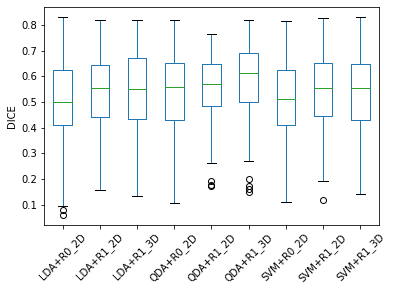

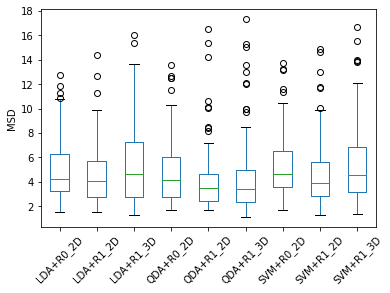

In [16]:
plt.figure()
boxplot_dicedist = df_dsc_Oxy.boxplot(grid=False, rot=45)
plt.ylabel('DICE')

plt.figure()
boxplot_dicedist = df_msd_Oxy.boxplot(grid=False, rot=45)
plt.ylabel('MSD')

# LARC + OxyTarget performance

In [17]:
LARC_Oxy_keys = ['ID_18','ID_19','ID_20','ID_21','ID_22','ID_23','ID_24'] #,'ID_25','ID_26']
resultPaths_LARC_Oxy = {x:resultPaths[x] for x in LARC_Oxy_keys}

In [18]:
#LARC_Oxy_groundTruthPaths = LARC_groundTruthPaths + Oxy_groundTruthPaths
LARC_Oxy_groundTruthPaths =  patientsPaths_groundTruth_corrected + Oxy_groundTruthPaths

In [19]:
dsc_LARC_Oxy, msd_LARC_Oxy = performance(resultPaths_LARC_Oxy, LARC_Oxy_groundTruthPaths)

ID_18
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-001.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-003.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-004.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-005.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-045.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-045/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-047.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-047/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-048.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-048/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-049.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-049/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-050.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-050/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-091.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-091/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-092.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-092/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-093.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-093/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-094.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-094/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-095.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-095/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_169_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_169_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_170_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_170_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_171_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_171_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_172_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_172_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_173_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_173_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_174_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_72_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_72_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_73_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_73_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_74_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_74_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_75_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_75_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_77_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_77_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_78_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_78_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-031.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-031/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-032.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-032/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-033.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-033/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-034.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-034/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-035.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-035/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-076.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-076/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-077.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-077/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-078.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-078/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-079.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-079/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/LARC-RRP-080.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-080/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_145_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_145_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_146_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_146_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_148_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_148_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_149_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_149_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_150_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_150_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_153_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_49_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_49_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_50_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_50_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_51_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_51_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_52_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_52_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_55_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_55_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_19/Oxytarget_56_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_56_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-019.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-019/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-020.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-020/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-021.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-021/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-022.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-022/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-023.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-023/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-067.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-067/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-068.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-068/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-069.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-069/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-070.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-070/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/LARC-RRP-071.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-071/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_125_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_125_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_126_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_126_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_128_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_128_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_130_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_130_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_131_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_28_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_28_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_29_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_29_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_31_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_31_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_32_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_32_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_40_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_40_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_20/Oxytarget_41_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_41_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-005.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-007.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-008.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-009.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-051.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-051/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-052.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-052/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-053.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-053/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-054.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-054/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/LARC-RRP-055.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_103_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_103_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_106_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_106_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_108_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_108_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_110_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_110_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_111_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_111_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_113_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_176_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_176_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_177_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_177_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_179_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_179_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_181_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_181_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_184_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_184_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_185_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_83_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_83_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_85_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_85_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_87_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_87_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_88_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_88_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_89_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_89_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_21/Oxytarget_90_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_90_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-037.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-037/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-038.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-038/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-039.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-040.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-040/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-041.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-085.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-085/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-086.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-086/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-087.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-087/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-088.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-088/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/LARC-RRP-089.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-089/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_156_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_156_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_157_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_157_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_160_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_160_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_162_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_162_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_163_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_163_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_164_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_58_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_58_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_59_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_59_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_61_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_61_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_64_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_64_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_65_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_65_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_22/Oxytarget_67_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_67_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-021.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-021/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-022.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-022/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-023.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-023/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-024.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-024/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-026.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-026/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-069.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-069/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-070.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-070/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-071.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-071/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-072.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-072/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-073.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-073/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_128_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_128_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_130_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_130_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_131_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_131_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_133_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_133_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_134_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_31_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_31_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_32_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_32_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_40_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_40_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_41_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_41_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_43_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_43_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/Oxytarget_44_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_44_PRE/

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-007.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-008.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-009.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-010.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-010/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-052.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-052/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-053.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-053/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-054.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-054/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-055.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-057.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-057/1 RTSTRUCT LARC_MRS1-label.nii
/User

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/LARC-RRP-099.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-099/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_103_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_103_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_106_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_106_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_108_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_108_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_110_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_110_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_111_PRE.nii
/Volumes/Untitled 1/O

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_176_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_176_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_177_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_177_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_179_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_179_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_181_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_181_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_184_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_184_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_185_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytar

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_80_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_80_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_83_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_83_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_85_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_85_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_87_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_87_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_88_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_88_PRE/Manual_an.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_24/Oxytarget_89_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_89_PRE/

In [20]:
df_dsc_LARC_Oxy, df_msd_LARC_Oxy, df_dscMean_LARC_Oxy, df_msdMean_LARC_Oxy, df_dscMedian_LARC_Oxy, df_msdMedian_LARC_Oxy = dataframes(dsc_LARC_Oxy, msd_LARC_Oxy)

LARC_Oxy_dfs = [df_dsc_LARC_Oxy, df_msd_LARC_Oxy, df_dscMean_LARC_Oxy, df_msdMean_LARC_Oxy]

for df in LARC_Oxy_dfs:
    df.rename(columns={'ID_18':'LDA+R0_2D','ID_19':'LDA+R1_2D','ID_20':'LDA+R1_3D','ID_21':'QDA+R0_2D','ID_22':'QDA+R1_2D','ID_23':'QDA+R1_3D','ID_24':'SVM+R0_2D'}, inplace=True)


print(df_dsc_LARC_Oxy)
print(df_msd_LARC_Oxy)
print((df_dscMean_LARC_Oxy.transpose()).to_latex())
print((df_msdMean_LARC_Oxy.transpose()).to_latex())
print(df_dscMedian_LARC_Oxy)
print(df_msdMedian_LARC_Oxy)

     LDA+R0_2D  LDA+R1_2D  LDA+R1_3D  QDA+R0_2D  QDA+R1_2D  QDA+R1_3D  \
0     0.561063   0.580304   0.658476   0.546360   0.527047   0.669782   
1     0.351099   0.383772   0.450385   0.404764   0.462763   0.483434   
2     0.497793   0.460923   0.497121   0.483230   0.371467   0.546452   
3     0.527607   0.369633   0.615064   0.500535   0.566721   0.483186   
4     0.131394   0.129421   0.096709   0.184673   0.203131   0.302131   
..         ...        ...        ...        ...        ...        ...   
194   0.583676   0.602173   0.370369   0.634319   0.521072   0.462228   
195   0.617994   0.646895   0.693122   0.605762   0.641032   0.700895   
196   0.702827   0.682498   0.653895   0.716853   0.706093   0.679538   
197   0.512844   0.518175   0.452739   0.411111   0.534248   0.519793   
198   0.370980   0.376784   0.458316   0.339645   0.497404   0.481294   

     SVM+R0_2D  
0     0.532164  
1     0.320321  
2     0.334424  
3     0.532686  
4     0.208357  
..         ...  
194 

Text(0, 0.5, 'MSD')

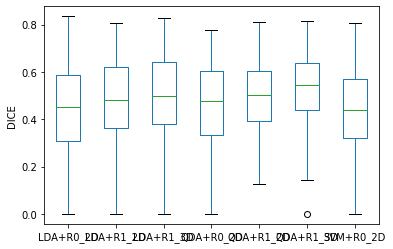

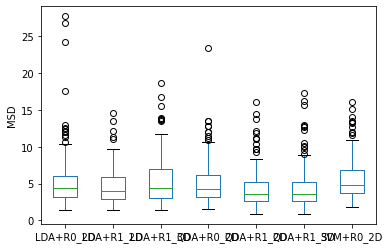

In [21]:
plt.figure()
boxplot_dicedist = df_dsc_LARC_Oxy.boxplot(grid=False)
plt.ylabel('DICE')

plt.figure()
boxplot_dicedist = df_msd_LARC_Oxy.boxplot(grid=False)
plt.ylabel('MSD')

# LARC old performance

In [64]:
LARC_patients, LARC_patientsNames, LARC_imagePaths, LARC_groundTruthPaths = gd.get_paths('/Volumes/Untitled/LARC_T2_preprocessed', image_prefix='image', mask_suffix='label.nii')
LARC_groundTruthPaths.insert(0, LARC_groundTruthPaths.pop(len(LARC_groundTruthPaths) - 1))
#print(LARC_groundTruthPaths)

In [65]:
LARC_old_keys = ['ID_0_old','ID_1_old','ID_2_old','ID_3_old','ID_4_old','ID_5_old','ID_6_old','ID_7_old','ID_8_old'] 
resultPaths_LARC_old = {x:resultPaths[x] for x in LARC_old_keys}

dsc_LARC_old, msd_LARC_old = performance(resultPaths_LARC_old, LARC_groundTruthPaths)

ID_0_old
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-001.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-003.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-004.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-005.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-006.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-007.nii
/Volumes/Unt

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-052.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-052/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-053.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-053/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-054.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-054/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-055.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-057.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-057/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0_old/LARC-RRP-058.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-008.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-009.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-010.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-010/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-011.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-011/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-013.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-013/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-014.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-059.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-059/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-060.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-060/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-062.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-062/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-064.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-064/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-065.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-065/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_1_old/LARC-RRP-066.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-016.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-016/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-017.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-017/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-018.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-018/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-019.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-019/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-020.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-020/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-021.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-069.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-069/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-070.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-070/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-071.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-071/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-072.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-072/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-073.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-073/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_2_old/LARC-RRP-074.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-022.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-022/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-023.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-023/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-024.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-024/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-026.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-026/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-027.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-027/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-028.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-075.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-075/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-076.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-076/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-077.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-077/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-078.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-078/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-079.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-079/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_3_old/LARC-RRP-080.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-030.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-030/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-031.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-031/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-032.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-032/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-033.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-033/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-034.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-034/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-035.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-083.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-083/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-084.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-084/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-085.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-085/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-086.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-086/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-087.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-087/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_4_old/LARC-RRP-088.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-037.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-037/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-038.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-038/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-039.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-040.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-040/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-041.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-042.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-090.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-090/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-091.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-091/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-092.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-092/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-093.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-093/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-094.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-094/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_5_old/LARC-RRP-095.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-044.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-044/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-045.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-045/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-047.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-047/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-048.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-048/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-049.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-049/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-050.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-096.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-096/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_6_old/LARC-RRP-099.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-099/1 RTSTRUCT LARC_MRS1-label.nii
ID_7_old
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-001.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-003.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-004.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-005.nii
/Volumes/Unt

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-051.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-051/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-052.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-052/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-053.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-053/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-054.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-054/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-055.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_7_old/LARC-RRP-057.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-007.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-008.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-009.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-010.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-010/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-011.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-011/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-013.nii
/Volumes/Untitled/LAR

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-064.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-064/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-065.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-065/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-066.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-066/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-067.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-067/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-068.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-068/1 RTSTRUCT LARC_MRS1-label.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8_old/LARC-RRP-069.nii
/Volumes/Untitled/LAR

In [66]:
df_dsc_LARC_old, df_msd_LARC_old, df_dscMean_LARC_old, df_msdMean_LARC_old, df_dscMedian_LARC_old, df_msdMedian_LARC_old = dataframes(dsc_LARC_old, msd_LARC_old)

LARC_old_dfs = [df_dsc_LARC_old, df_msd_LARC_old, df_dscMean_LARC_old, df_msdMean_LARC_old]

for df in LARC_old_dfs:
    df.rename(columns={'ID_0_old':'LDA+R0_2D','ID_1_old':'LDA+R1_2D','ID_2_old':'LDA+R1_3D','ID_3_old':'QDA+R0_2D','ID_4_old':'QDA+R1_2D','ID_5_old':'QDA+R1_3D','ID_6_old':'SVM+R0_2D','ID_7_old':'SVM+R1_2D','ID_8_old':'SVM+R1_3D'}, inplace=True)


In [67]:
print(df_dsc_LARC_old)
print(df_msd_LARC_old)
print(df_dscMean_LARC_old)
print(df_msdMean_LARC_old)
print(df_dscMedian_LARC_old)
print(df_msdMedian_LARC_old)

    LDA+R0_2D  LDA+R1_2D  LDA+R1_3D  QDA+R0_2D  QDA+R1_2D  QDA+R1_3D  \
0    0.553876   0.522740   0.643150   0.512925   0.472703   0.619585   
1    0.397152   0.403267   0.484959   0.369104   0.433194   0.422728   
2    0.480061   0.407189   0.474166   0.444403   0.376555   0.459345   
3    0.566429   0.558837   0.571160   0.496647   0.466154   0.598944   
4    0.145138   0.146763   0.158309   0.222109   0.344293   0.338410   
..        ...        ...        ...        ...        ...        ...   
84   0.208960   0.535290   0.315595   0.419543   0.395057   0.235386   
85   0.549996   0.550492   0.639352   0.497423   0.480861   0.560340   
86   0.263195   0.302239   0.368296   0.261283   0.350607   0.264270   
87   0.482775   0.345697   0.406463   0.503506   0.275613   0.468855   
88   0.306427   0.303518   0.397664   0.275763   0.251771   0.363946   

    SVM+R0_2D  SVM+R1_2D  SVM+R1_3D  
0    0.517814   0.534671   0.629262  
1    0.379072   0.394357   0.449307  
2    0.350542   0.454

In [68]:
list_old = df_dsc_LARC_old['LDA+R0_2D'].tolist()
mask_old = sitk.ReadImage(str(resultPaths_LARC_old['ID_0_old'][0]))
mask = sitk.ReadImage(str(resultPaths_LARC['ID_0'][0]))
mask_gt = sitk.ReadImage(str(LARC_groundTruthPaths[0]))
mask_gt_corr = sitk.ReadImage('/Volumes/Untitled/Problematic_patients_RW_preprocessed/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii')

dice_old = calculate_dice(mask_old, mask_gt)
#print(dice_old)

dice_new = calculate_dice(mask, mask_gt_corr)
#print(dice_new)

print(patientsPaths_groundTruth_corrected[58])
print(LARC_groundTruthPaths[58])
print(df_dsc_LARC_old['LDA+R0_2D'][58])
print(df_dsc_LARC['LDA+R0_2D'][58])

print(df_msd_LARC_old['LDA+R0_2D'][58])
print(df_msd_LARC['LDA+R0_2D'][58])


/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-066/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-066/1 RTSTRUCT LARC_MRS1-label.nii
0.3840225116644769
0.4375556743274541
4.923686211502353
3.233675162560766


# Plotting

In [22]:
#DSC
df_dsc_LARC['Data'] = 'LARC'
df_dsc_Oxy['Data'] = 'OxyTarget'
df_dsc_LARC_Oxy['Data'] = 'LARC+OxyTarget'

cdf_dsc = pd.concat([df_dsc_LARC, df_dsc_Oxy, df_dsc_LARC_Oxy])

mdf_dsc = pd.melt(cdf_dsc, id_vars=['Data'], var_name=['Parameters'])
mdf_dsc[['Classification','Unfolding']] = mdf_dsc.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
#print(mdf_dsc)

#MSD
df_msd_LARC['Data'] = 'LARC'
df_msd_Oxy['Data'] = 'OxyTarget'
df_msd_LARC_Oxy['Data'] = 'LARC+OxyTarget'

cdf_msd = pd.concat([df_msd_LARC, df_msd_Oxy, df_msd_LARC_Oxy])

mdf_msd = pd.melt(cdf_msd, id_vars=['Data'], var_name=['Parameters'])
mdf_msd[['Classification','Unfolding']] = mdf_msd.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
#print(mdf_dsc)

In [69]:
df_dsc_LARC_old['Data'] = 'Old NIfTI masks'
df_dsc_LARC['Data'] = 'Corrected NIfTI masks'

cdf_dsc_compare = pd.concat([df_dsc_LARC_old, df_dsc_LARC])

mdf_dsc_compare = pd.melt(cdf_dsc_compare, id_vars=['Data'], var_name=['Parameters'])
mdf_dsc_compare[['Classification','Unfolding']] = mdf_dsc_compare.Parameters.apply(lambda x: pd.Series(str(x).split("+")))

#print(mdf_dsc_compare)

df_msd_LARC_old['Data'] = 'Old NIfTI masks'
df_msd_LARC['Data'] = 'Corrected NIfTI masks'

cdf_msd_compare = pd.concat([df_msd_LARC_old, df_msd_LARC])

mdf_msd_compare = pd.melt(cdf_msd_compare, id_vars=['Data'], var_name=['Parameters'])
mdf_msd_compare[['Classification','Unfolding']] = mdf_msd_compare.Parameters.apply(lambda x: pd.Series(str(x).split("+")))

#print(mdf_msd_compare)





In [74]:
def plot_box(dataframe, ylabel):

    plt.figure()
    g = sns.FacetGrid(dataframe, col='Unfolding', row='Classification',margin_titles=True)
    g.map(sns.boxplot,'Data', 'value', palette=['skyblue','orange','mediumseagreen'])
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')

        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
    
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', ylabel)
    g.set(ylim=(-0.05,1.05))
    plt.show()

#    plt.figure()
#    g = sns.catplot(x='Unfolding', y='value', hue='Data', col='Classification', data=dataframe, kind='box', palette=['skyblue','orange','mediumseagreen'])
#    g.set_axis_labels('', ylabel)
#    g.set(ylim=(0,1.1))
#    plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

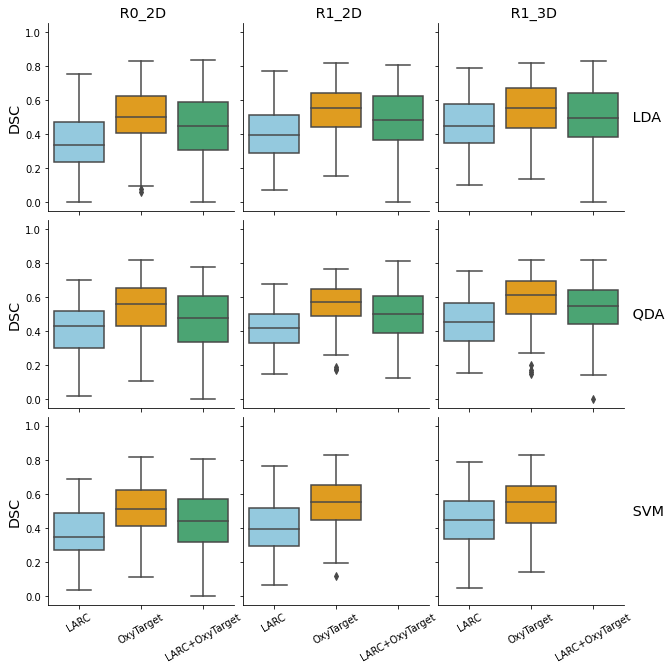

In [57]:
plot_box(mdf_dsc, 'DSC')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

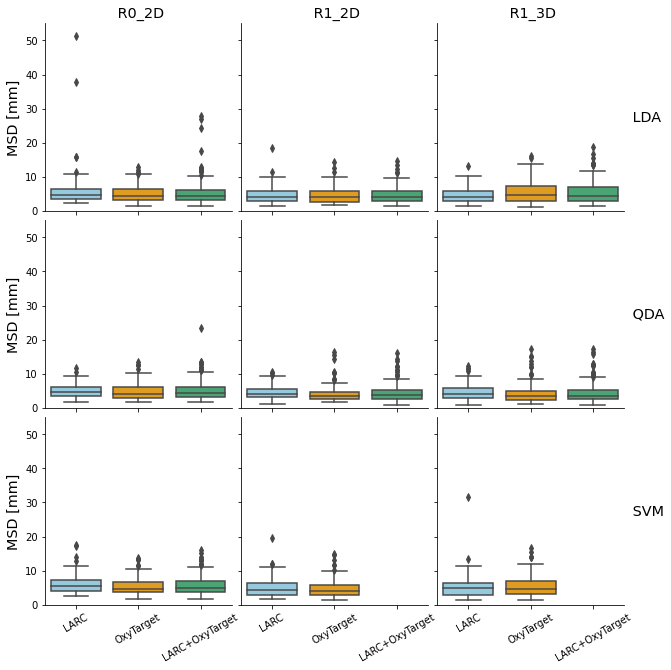

In [62]:
plot_box(mdf_msd, 'MSD [mm]')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

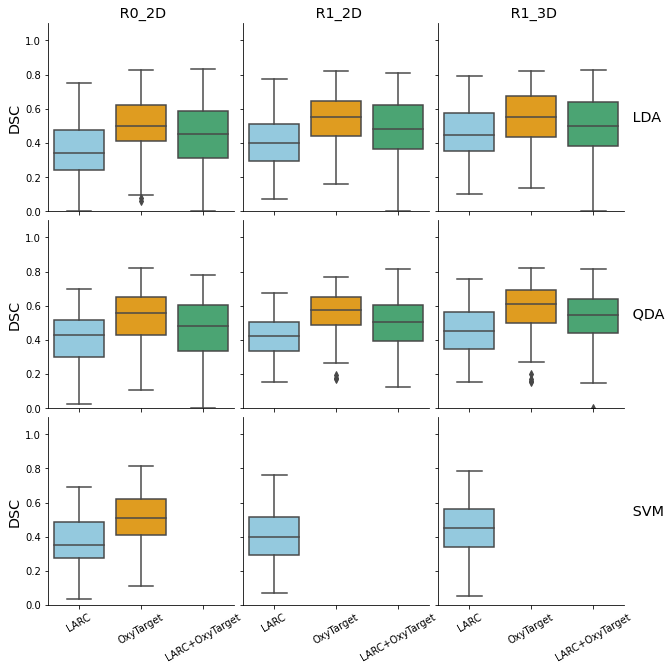

<Figure size 432x288 with 0 Axes>

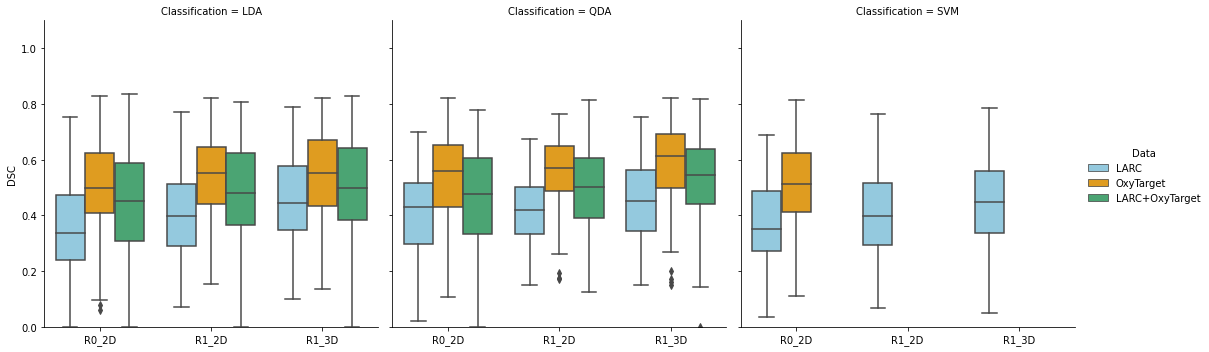

In [32]:
plot_box(mdf_dsc, 'DSC')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

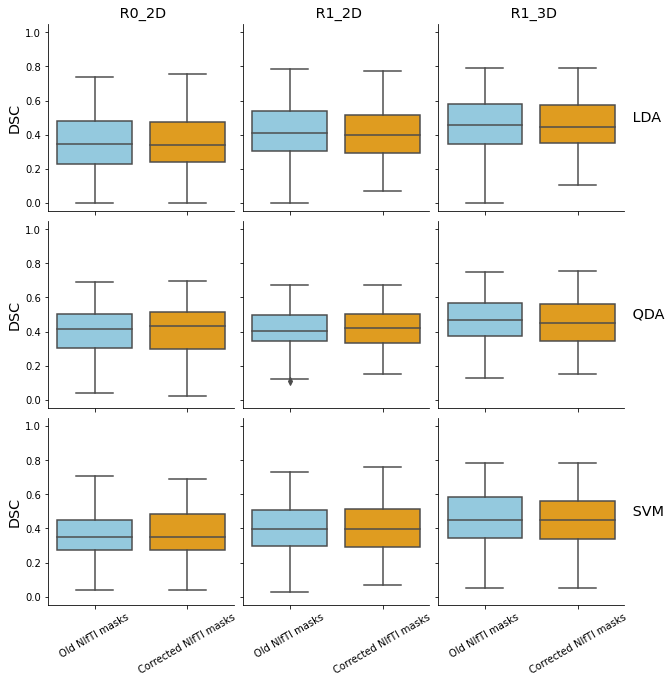

In [76]:
plot_box(mdf_dsc_compare, 'DSC')

In [34]:
print(df_dsc_LARC.max())
print(df_dsc_Oxy.max())
print(df_dsc_LARC_Oxy.max())

LDA+R0_2D                 0.752825
LDA+R1_2D                 0.771978
LDA+R1_3D                 0.790289
QDA+R0_2D                   0.6983
QDA+R1_2D                 0.674699
QDA+R1_3D                 0.754925
SVM+R0_2D                 0.689829
SVM+R1_2D                 0.762332
SVM+R1_3D                 0.786451
Data         Corrected NIfTI masks
dtype: object
LDA+R0_2D     0.829094
LDA+R1_2D     0.820441
LDA+R1_3D     0.820732
QDA+R0_2D     0.819772
QDA+R1_2D     0.765639
QDA+R1_3D     0.820024
SVM+R0_2D     0.815697
Data         OxyTarget
dtype: object
LDA+R0_2D          0.835262
LDA+R1_2D          0.808388
LDA+R1_3D          0.827809
QDA+R0_2D          0.777908
QDA+R1_2D           0.81288
QDA+R1_3D          0.816513
Data         LARC+OxyTarget
dtype: object


In [35]:
print(df_dsc_LARC_Oxy.max())
max_value = df_dsc_LARC_Oxy['LDA+R0_2D'].tolist()
print(max(max_value))
print(max_value.index(max(max_value)))
print(resultPaths_LARC_Oxy['ID_18'][181])
msd_list = df_msd_LARC_Oxy['LDA+R0_2D'].tolist()
print(msd_list[181])

LDA+R0_2D          0.835262
LDA+R1_2D          0.808388
LDA+R1_3D          0.827809
QDA+R0_2D          0.777908
QDA+R1_2D           0.81288
QDA+R1_3D          0.816513
Data         LARC+OxyTarget
dtype: object
0.8352615756142037
181
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/Oxytarget_74_PRE.nii
2.3262096709582787


In [36]:
print(df_dsc_LARC.min())
print(df_dsc_Oxy.min())
print(df_dsc_LARC_Oxy.min())

LDA+R0_2D                        0
LDA+R1_2D                0.0715444
LDA+R1_3D                  0.10183
QDA+R0_2D                0.0226519
QDA+R1_2D                 0.149246
QDA+R1_3D                 0.151834
SVM+R0_2D                0.0368254
SVM+R1_2D                0.0678463
SVM+R1_3D                0.0503912
Data         Corrected NIfTI masks
dtype: object
LDA+R0_2D    0.0614187
LDA+R1_2D     0.155708
LDA+R1_3D      0.13538
QDA+R0_2D     0.106449
QDA+R1_2D     0.171393
QDA+R1_3D     0.150005
SVM+R0_2D     0.110526
Data         OxyTarget
dtype: object
LDA+R0_2D                 0
LDA+R1_2D                 0
LDA+R1_3D                 0
QDA+R0_2D                 0
QDA+R1_2D          0.124782
QDA+R1_3D                 0
Data         LARC+OxyTarget
dtype: object


In [80]:
print(df_dsc_LARC.min())
min_value = df_dsc_LARC['LDA+R0_2D'].tolist()
print(min(min_value))
print(min_value.index(min(min_value)))
print(resultPaths_LARC['ID_0'][64])
msd_list = df_msd_LARC['LDA+R0_2D'].tolist()
print(msd_list[64])

LDA+R0_2D                        0
LDA+R1_2D                0.0715444
LDA+R1_3D                  0.10183
QDA+R0_2D                0.0226519
QDA+R1_2D                 0.149246
QDA+R1_3D                 0.151834
SVM+R0_2D                0.0368254
SVM+R1_2D                0.0678463
SVM+R1_3D                0.0503912
Data         Corrected NIfTI masks
dtype: object
0.0
64
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-072.nii
nan


In [37]:
print(df_msd_LARC.min())
print(df_msd_Oxy.min())
print(df_msd_LARC_Oxy.min())

LDA+R0_2D                  2.42319
LDA+R1_2D                  1.47927
LDA+R1_3D                  1.33607
QDA+R0_2D                  1.76361
QDA+R1_2D                 0.969221
QDA+R1_3D                 0.920153
SVM+R0_2D                  2.52989
SVM+R1_2D                  1.51948
SVM+R1_3D                  1.41341
Data         Corrected NIfTI masks
dtype: object
LDA+R0_2D      1.52308
LDA+R1_2D      1.56303
LDA+R1_3D      1.26329
QDA+R0_2D      1.72055
QDA+R1_2D      1.67066
QDA+R1_3D      1.15599
SVM+R0_2D      1.68917
Data         OxyTarget
dtype: object
LDA+R0_2D           1.38117
LDA+R1_2D           1.41065
LDA+R1_3D           1.35444
QDA+R0_2D           1.53917
QDA+R1_2D          0.921831
QDA+R1_3D           0.87777
Data         LARC+OxyTarget
dtype: object


In [38]:
min_msd_value = df_msd_LARC_Oxy['QDA+R1_3D'].tolist()
print(min(min_msd_value))
print(min_msd_value.index(min(min_msd_value)))
print(resultPaths_LARC_Oxy['ID_23'][16])
dsc_list = df_dsc_LARC_Oxy['QDA+R1_3D'].tolist()
print(dsc_list[16])

0.8777697862282523
16
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_23/LARC-RRP-019.nii
0.6835232847762095


In [39]:
print(df_msd_LARC.max())
print(df_msd_Oxy.max())
print(df_msd_LARC_Oxy.max())

LDA+R0_2D                  51.4218
LDA+R1_2D                  18.3411
LDA+R1_3D                  13.2033
QDA+R0_2D                  11.5411
QDA+R1_2D                  10.3856
QDA+R1_3D                  12.1805
SVM+R0_2D                  17.4878
SVM+R1_2D                  19.6159
SVM+R1_3D                  31.4539
Data         Corrected NIfTI masks
dtype: object
LDA+R0_2D      12.7628
LDA+R1_2D      14.3951
LDA+R1_3D      16.0095
QDA+R0_2D      13.5644
QDA+R1_2D      16.5035
QDA+R1_3D      17.3285
SVM+R0_2D      13.7086
Data         OxyTarget
dtype: object
LDA+R0_2D           27.6996
LDA+R1_2D           14.5608
LDA+R1_3D           18.6096
QDA+R0_2D           23.3891
QDA+R1_2D           16.0704
QDA+R1_3D           17.3414
Data         LARC+OxyTarget
dtype: object


In [40]:
print(df_msd_LARC.max())
max_msd_LDA = df_msd_LARC['LDA+R0_2D'].tolist()
print(max(max_msd_LDA))
print(max_msd_LDA.index(max(max_msd_LDA)))
print(resultPaths_LARC['ID_0'][78])
dsc_list = df_dsc_LARC['LDA+R0_2D'].tolist()
print(dsc_list[78])

LDA+R0_2D                  51.4218
LDA+R1_2D                  18.3411
LDA+R1_3D                  13.2033
QDA+R0_2D                  11.5411
QDA+R1_2D                  10.3856
QDA+R1_3D                  12.1805
SVM+R0_2D                  17.4878
SVM+R1_2D                  19.6159
SVM+R1_3D                  31.4539
Data         Corrected NIfTI masks
dtype: object
51.42177790533682
78
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-087.nii
0.018166908471582664


In [41]:
max_msd_SVM = df_msd_LARC['SVM+R1_3D'].tolist()
print(max(max_msd_SVM))
print(max_msd_SVM.index(max(max_msd_SVM)))
print(resultPaths_LARC['ID_8'][15])
dsc_list = df_dsc_LARC['SVM+R1_3D'].tolist()
print(dsc_list[15])

31.453902958877546
15
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_8/LARC-RRP-018.nii
0.05039120530850748


In [42]:
print(df_msd_LARC_Oxy.max())
max_msd_LDA = df_msd_LARC_Oxy['LDA+R0_2D'].tolist()
print(max(max_msd_LDA))
print(max_msd_LDA.index(max(max_msd_LDA)))
print(resultPaths_LARC_Oxy['ID_18'][15])
dsc_list = df_dsc_LARC_Oxy['LDA+R0_2D'].tolist()
print(dsc_list[15])

LDA+R0_2D           27.6996
LDA+R1_2D           14.5608
LDA+R1_3D           18.6096
QDA+R0_2D           23.3891
QDA+R1_2D           16.0704
QDA+R1_3D           17.3414
Data         LARC+OxyTarget
dtype: object
27.699630793853352
15
/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_18/LARC-RRP-018.nii
0.006043785295598967


In [43]:
print(resultPaths_LARC['ID_0'][47])

/Users/ingvild/Documents/Prosjektoppgave/Data/results_postprocessed/ID_0/LARC-RRP-052.nii


In [44]:
ID_0 = df_dsc_LARC['LDA+R0_2D'].tolist()
print(ID_0[47])

ID_1 = df_dsc_LARC['LDA+R1_2D'].tolist()
print(ID_1[47])

ID_2 = df_dsc_LARC['LDA+R1_3D'].tolist()
print(ID_2[47])

ID_3 = df_dsc_LARC['QDA+R0_2D'].tolist()
print(ID_3[47])

ID_4 = df_dsc_LARC['QDA+R1_2D'].tolist()
print(ID_4[47])

ID_5 = df_dsc_LARC['QDA+R1_3D'].tolist()
print(ID_5[47])

ID_6 = df_dsc_LARC['SVM+R0_2D'].tolist()
print(ID_6[47])

ID_7 = df_dsc_LARC['SVM+R1_2D'].tolist()
print(ID_7[47])

ID_8 = df_dsc_LARC['SVM+R1_3D'].tolist()
print(ID_8[47])

0.3723955107400342
0.36099557374496766
0.5406333870101986
0.37779105604126045
0.444339955330904
0.45659781788238524
0.385550677610231
0.44831420036703146
0.5334614376801468


In [45]:
ID_0 = df_msd_LARC['LDA+R0_2D'].tolist()
print(ID_0[47])

ID_1 = df_msd_LARC['LDA+R1_2D'].tolist()
print(ID_1[47])

ID_2 = df_msd_LARC['LDA+R1_3D'].tolist()
print(ID_2[47])

ID_3 = df_msd_LARC['QDA+R0_2D'].tolist()
print(ID_3[47])

ID_4 = df_msd_LARC['QDA+R1_2D'].tolist()
print(ID_4[47])

ID_5 = df_msd_LARC['QDA+R1_3D'].tolist()
print(ID_5[47])

ID_6 = df_msd_LARC['SVM+R0_2D'].tolist()
print(ID_6[47])

ID_7 = df_msd_LARC['SVM+R1_2D'].tolist()
print(ID_7[47])

ID_8 = df_msd_LARC['SVM+R1_3D'].tolist()
print(ID_8[47])

5.9998168661969755
5.484403828957531
2.687033987011416
3.7385028745400275
2.8095417820937048
6.262374505606317
4.37267878460814
3.2083340137771326
2.758285269930094
